# Bank Underwriting & Bank Guarantee Rules

This code will analyze the possibility that there were **"implicit"** rules used by Estonian bankers from 1921-1930, with Period 0 from 1921-1925 and Period 1 from 1926-1930. 

The hypothesis posits that banks forced the bank's underwriters to guarantee a portion of the security they were purchasing in order to hedge against the possibility that the price is too high and thus is unable to be flipped for a profit, as the security was purchased for the purpose of making a profit and not holding it. 

In [2]:
#Import packages 
import pandas as pd #pandas for data management (dataframes etc)
import matplotlib.pyplot as plt #matplotlib for plotting
import numpy as np #numpy for array operations
from sklearn.model_selection import train_test_split #data splitting
from sklearn.tree import DecisionTreeRegressor, plot_tree #regression trees

In [3]:
#Load bank dataset and turn underwriting units into per $100k
bank = pd.read_csv("https://raw.githubusercontent.com/sahilh99/Sahil-Habibi-Econ-Research-Code/refs/heads/main/Pricing%20Models/Bank%20Loan%20Pricing%20Model/bankdata.csv")
bank['bankunderwriting'] = bank['bankunderwriting']/100000

In [4]:
#View dataset
bank

,date,period,bankerguarantee,bankunderwriting
0,8/4/1926,0,0,0.03000
1,2/1/1927,0,0,0.40000
2,6/24/1929,0,0,0.82175
3,12/4/1926,0,2000,1.00000
4,10/7/1925,0,4000,1.15000
...,...,...,...,...
215,2/26/1925,1,80000,30.34000
216,6/16/1920,1,80000,31.90000
217,9/15/1922,1,100000,36.15000
218,11/17/1920,1,100000,39.20000


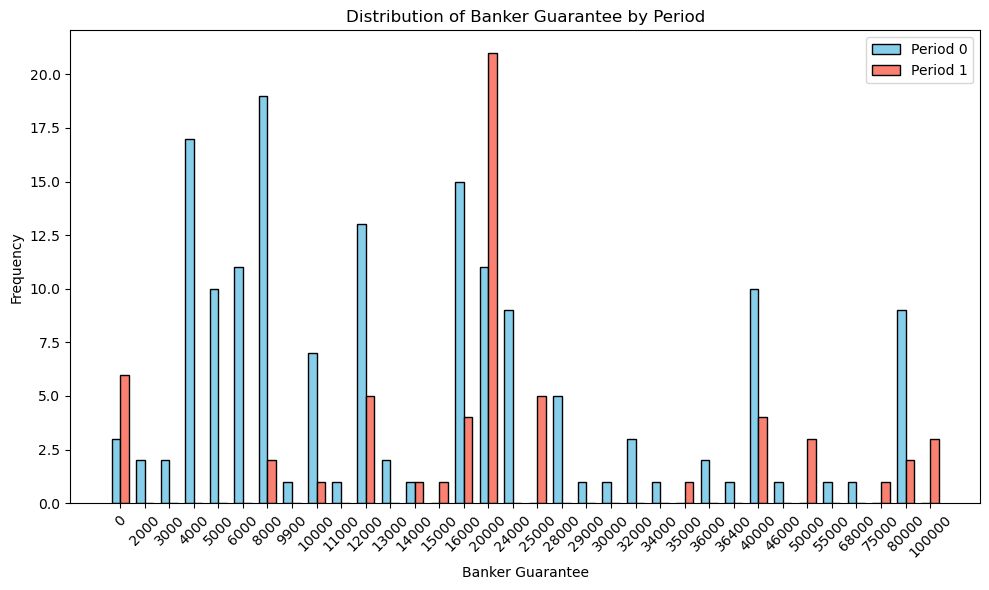

In [5]:
#Collect the values for the variable for each period
counts_0 = bank[bank["period"] == 0]["bankerguarantee"].value_counts().sort_index()
counts_1 = bank[bank["period"] == 1]["bankerguarantee"].value_counts().sort_index()

#Ensure both Series have the same index for alignment
all_guarantee_levels = sorted(set(counts_0.index).union(set(counts_1.index)))
counts_0 = counts_0.reindex(all_guarantee_levels, fill_value=0)
counts_1 = counts_1.reindex(all_guarantee_levels, fill_value=0)

#Plot the bar graph
x = np.arange(len(all_guarantee_levels))  
width = 0.35  #Bar width

#Create the figure
plt.figure(figsize=(10, 6)) 
#Create the bars
plt.bar(x - width/2, counts_0.values, width=width, label='Period 0', color='skyblue', edgecolor='black')
plt.bar(x + width/2, counts_1.values, width=width, label='Period 1', color='salmon', edgecolor='black')

#Give the x-ticks a 45 degree angle for viewing purposes
plt.xticks(x, all_guarantee_levels, rotation=45)
#X-label
plt.xlabel("Banker Guarantee")
#Y-label
plt.ylabel("Frequency")
#Graph title
plt.title("Distribution of Banker Guarantee by Period")
#Add a legend to the plot for consumption
plt.legend()
#Set a tight layout
plt.tight_layout()
#Save the figure
plt.savefig("Banker Guarantee.png")
#Display for viewing"
plt.show()


## Decision Tree Analysis

## Strategy: 
Break the data into two periods to analyze the rule in both periods. Use a split of data to use as a training and testing. Use decision trees to create a rule to fit the data based on the training data. This decision tree regression will analyze the data to see if there is a potential rule that can be generated from machine learning through the decision tree, which will indicate the potential for an unspoken rule in underwriting bank securities that existed in Estonia from 1921-1930.

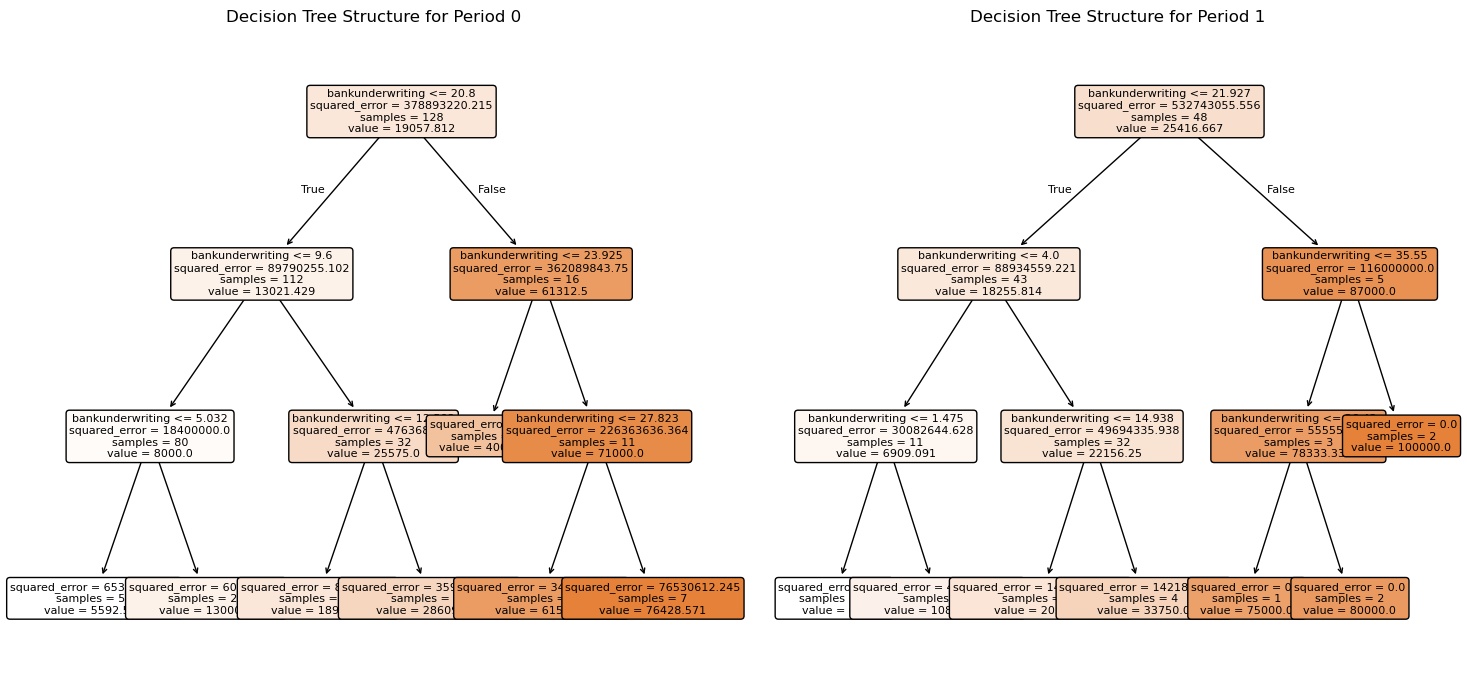

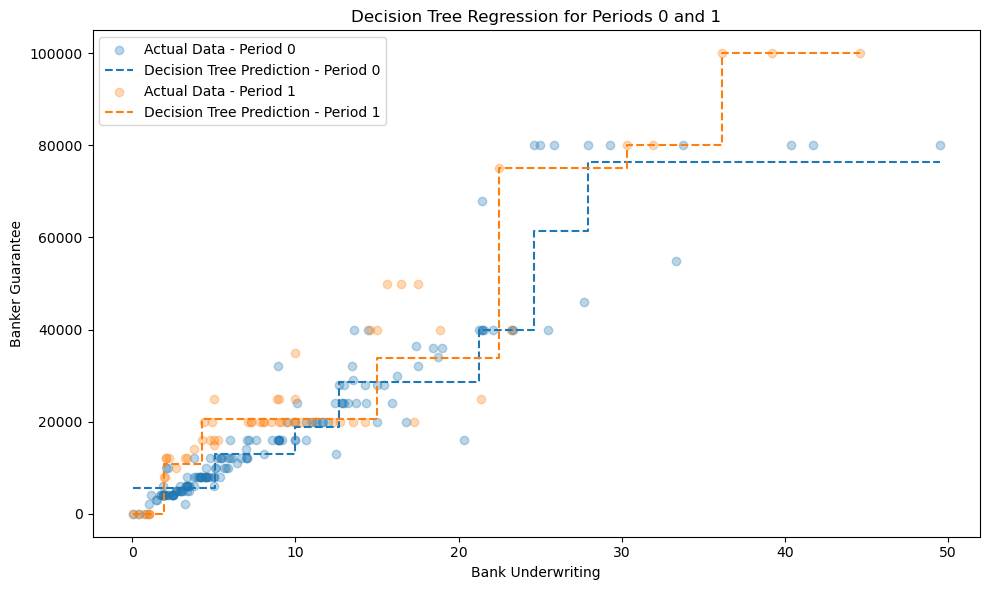

In [59]:
#Want tree for two periods, 0 and 1
periods = [0, 1]

#Store the tree models
tree_models = {}

#Make sure the DataFrame is sorted by period and bankunderwriting
bank = bank.sort_values(by=["period", "bankunderwriting"])

#Create a side-by-side plot of the two trees
plt.figure(figsize=(15, 7))
for i, period in enumerate(periods):
    #Load current data's period
    data_period = bank[bank["period"] == period].copy()
    
    #Bank underwriting is the predictor for banker guarantee
    X = data_period[["bankunderwriting"]]
    y = data_period["bankerguarantee"]
    
    #Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Train a decision tree regressor
    #Want a step function, so we limit max_depth to just 3 to limit the number of splits for the tree
    tree_reg = DecisionTreeRegressor(max_depth=3, random_state=42)
    tree_reg.fit(X_train, y_train)
    
    #Store model results
    tree_models[period] = tree_reg
    
    #Plot tree structure
    plt.subplot(1, 2, i+1)
    plot_tree(tree_reg, feature_names=["bankunderwriting"], filled=True, rounded=True, fontsize=8)
    plt.title(f"Decision Tree Structure for Period {period}") #title

#Tighten layout
plt.tight_layout()
#View the graph
plt.show()

#Visualize the step functions
plt.figure(figsize=(10, 6))
for period in periods:
    #Go through each period
    data_period = bank[bank["period"] == period].copy()
    X = data_period[["bankunderwriting"]]
    y = data_period["bankerguarantee"]
    
    #Create a scatter plot
    plt.scatter(X, y, alpha=0.3, label=f"Actual Data - Period {period}")
    
    #Prepare the data for a prediction line
    unique_x = np.sort(X["bankunderwriting"].unique())
    # Create a DataFrame so the predict() method gets valid feature names
    X_sorted = pd.DataFrame(unique_x.reshape(-1, 1), columns=["bankunderwriting"])
    
    #Using the decision tree, construct the prediction line
    y_pred = tree_models[period].predict(X_sorted)
    
    #Plot the prediction as a step-line
    plt.plot(X_sorted, y_pred, linestyle="dashed", drawstyle="steps-post",
             label=f"Decision Tree Prediction - Period {period}")

plt.xlabel("Bank Underwriting") #xlabel
plt.ylabel("Banker Guarantee") #ylabel
plt.title("Decision Tree Regression for Periods 0 and 1") #title
plt.legend() #legend
plt.tight_layout() #tighten layout
plt.show() #show the plot
